In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array
from scipy import linalg as la
from haversine import haversine

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')

In [3]:
em = full_data.values
em = em [:,2:4]

In [4]:
ems_locs = [[39.8260114,-86.0761364], [39.6568599,-86.1601396], [39.7732962,-86.1041378], 
            [39.7368328,-86.1503765], [39.8123208,-86.2047758], [39.8316109,-86.1467804], 
            [39.7827679,-85.9779839], [39.7520358,-86.0286547], [39.810177,-86.0407634], 
            [39.6779709,-86.0644407], [39.6513072,-86.0557181], [39.800967,-86.2618977], 
            [39.8329387,-85.9938128], [39.7509044,-86.1431251], [39.9087467,-86.1866223], 
            [39.795554,-86.1695443],  [39.8263546,-86.1058871], [39.7668563,-86.1321774], 
            [39.8540269,-86.200319], [39.6794523,-86.0208083],  [39.8902542,-86.0448717], 
            [39.7664619,-86.2092232], [39.7874424,-86.0773693], [39.8835439,-86.1220856], [39.6938768,-86.1408689]]
ems_locs = np.array (ems_locs)

In [5]:
#assume 1/2 of the stations will have immovable ambulances

In [7]:
print ((full_data['DATE_TIME'] [st+50] - full_data['DATE_TIME'] [st]).total_seconds() / (15 * 60)) 
print ((full_data['DATE_TIME'] [st+50] - full_data['DATE_TIME'] [st])) 

13.093333333333334
0 days 03:16:24


In [22]:
interval_count = 14
st = len(full_data) - 8000
PointProcess = PointProcessRun(param_location = 'Trained_Params_.npz')
start_time = full_data['DATE_TIME'] [st]
grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = 80)

In [21]:
mx = 50
still_data = ems_locs
cluster = Cluster(grid_loc, n = len(ems_locs))
cluster.set_centers (ems_locs, n = len(ems_locs))
cluster.remove_points (still_data)
#lam = cluster.learn_lam(n_iter = 10, rand_centers = False)
#cluster.round_off()
cluster.process_data_kmeans(True)
centers = cluster.get_centers()
data = cluster.get_data()

0 points removed


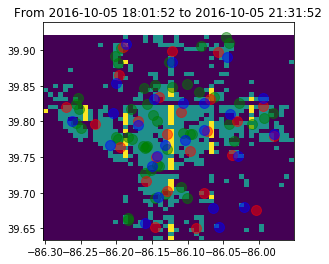

In [23]:
bincount = 50
data = grid_loc
end_time = start_time + datetime.timedelta(seconds = 15*60*interval_count)
heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title ('From {} to {}'.format(str(start_time), str(end_time)))
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.scatter(em[st:st+mx,1], em[st:st+mx,0], c = 'green', s = 100, alpha = 0.5)
plt.scatter(centers[:,1], centers[:,0], c = 'red', s= 100, alpha = 0.5)
plt.scatter(still_data[:,1], still_data[:,0], c = 'blue', s = 100, alpha = 0.5)
#plt.scatter(ems_locs[13:26,1], ems_locs[13:26,0], c = 'red', s = 100, alpha = 0.5)
plt.show()
plt.close()

412 points removed


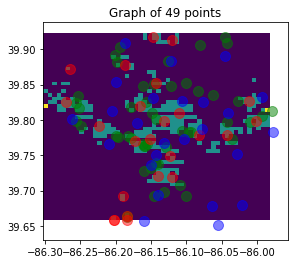

405 points removed


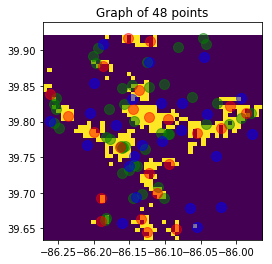

423 points removed


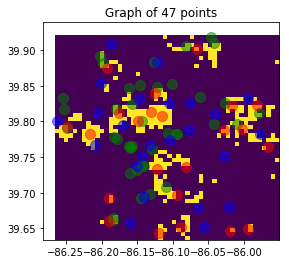

396 points removed


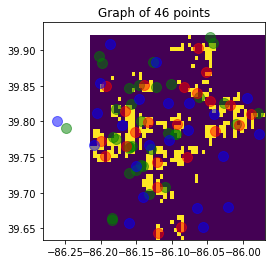

386 points removed


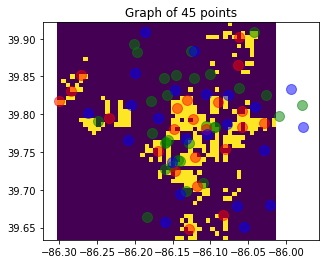

374 points removed


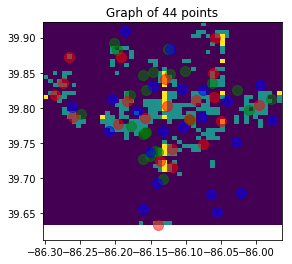

424 points removed


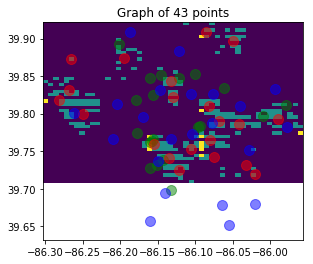

414 points removed


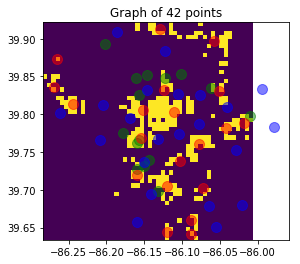

371 points removed


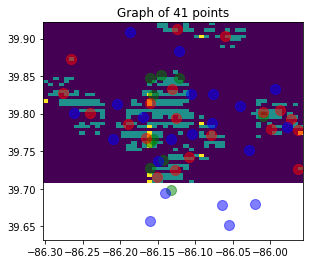

434 points removed


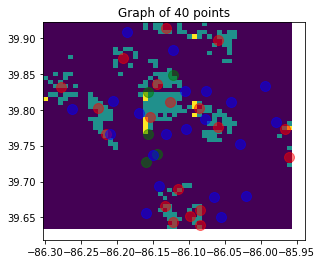

In [17]:
all_driving = np.empty ([0])
tp_rm_any = False
for x in range (mx):    
    emergency = [0,0]
    emergency [1] = full_data ['XCOORD'] [st + x]
    emergency [0] = full_data ['YCOORD'] [st + x]
    '''
    update = [{
        'XCOORD': full_data ['XCOORD'] [st + x],
        'YCOORD': full_data ['YCOORD'] [st + x],
        'DATE_TIME': full_data ['DATE_TIME'] [st + x]
    }]
    
    update = pd.DataFrame (update)
    '''
    #PointProcess.update_from_new_inputs(update, save_out = False)
    grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = 80)
    
    total_data = np.concatenate ((centers, still_data))

    #find closest center
    mindist = 9999
    for i in range (len(total_data)):
        dist = la.norm (total_data [i, 0:2] - emergency)
        if (dist < mindist):
            mindist = dist
            truck_point = total_data [i, 0:2]
            pos = i
            
    if (x % (mx / 10) == 0):
        start_time = full_data['DATE_TIME'] [st+x]
        #remove from either the movable or immovable points
        if (pos < len(centers)):
            centers = np.delete (centers, pos, 0)
            total_data = np.delete (total_data, pos, 0)
        else:
            still_data = np.delete (still_data, pos - len(centers), 0)
            total_data = np.delete (total_data, pos, 0)
            
        #total_data = np.concatenate ((centers, ems_locs[0:13]))
        tp_rm_any = True
        tp_rm = truck_point
        
        cluster = Cluster(grid_loc, n = len(centers))
        cluster.remove_points (still_data)
        cluster.set_centers (centers[:,0:2], len(centers))
        #lam = cluster.learn_lam(n_iter = 10, rand_centers = False)
        #cluster.round_off()
        cluster.process_data_kmeans(True)
        centers = cluster.get_centers()
        data = cluster.get_data()
        
        heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        plt.clf()
        plt.title ('Graph of {} points'.format(str(len(total_data))))
        plt.imshow(heatmap.T, extent=extent, origin='lower')
        plt.scatter(em[st+x:st+mx,1], em[st+x:st+mx,0], c = 'green', s = 100, alpha = 0.5)
        plt.scatter(centers[:,1], centers[:,0], c = 'red', s = 100, alpha = 0.5)
        plt.scatter(still_data[:,1], still_data[:,0], c = 'blue', s = 100, alpha = 0.5)
        plt.show()
        plt.close()
        
        #find driving distance to that point
    #driving_distance = cluster.driving_distance (emergency, truck_point)
    driving_distance = haversine (emergency, truck_point, miles = True)
    all_driving = np.append (all_driving, driving_distance)

In [24]:
''' 
##########
# FOR NO CLUSTERING
##########
''' 
centers = ems_locs
all_driving = np.empty ([0])
tp_rm_any = False
for x in range (mx):    
    emergency = [0,0]
    emergency [1] = full_data ['XCOORD'] [st + x]
    emergency [0] = full_data ['YCOORD'] [st + x]
    
    total_data = np.concatenate ((centers, still_data))

    #find closest center
    mindist = 9999
    for i in range (len(total_data)):
        dist = la.norm (total_data [i, 0:2] - emergency)
        if (dist < mindist):
            mindist = dist
            truck_point = total_data [i, 0:2]
            pos = i
            
    if (x % (mx / 10) == 0):
        start_time = full_data['DATE_TIME'] [st+x]
        #remove from either the movable or immovable points
        if (pos < len(centers)):
            centers = np.delete (centers, pos, 0)
            total_data = np.delete (total_data, pos, 0)
        else:
            still_data = np.delete (still_data, pos - len(centers), 0)
            total_data = np.delete (total_data, pos, 0)
            
        #total_data = np.concatenate ((centers, ems_locs[0:13]))
        tp_rm_any = True
        tp_rm = truck_point
        
    #find driving distance to that point
    #driving_distance = cluster.driving_distance (emergency, truck_point)
    driving_distance = haversine (emergency, truck_point, miles = True)
    all_driving = np.append (all_driving, driving_distance)

[1.483 0.921 1.099 0.891 1.536 1.624 0.366 0.523 1.754 2.183 2.204 1.249
 0.258 0.931 2.285 1.445 1.316 1.432 1.916 1.421 1.334 1.34  1.942 0.746
 0.397 1.951 0.959 0.562 1.319 0.196 1.202 0.866 0.787 1.633 1.612 1.386
 1.495 0.955 1.849 0.368 1.367 1.318 0.565 1.849 1.89  1.723 0.391 1.293
 0.703 0.847]
1.234
1.318


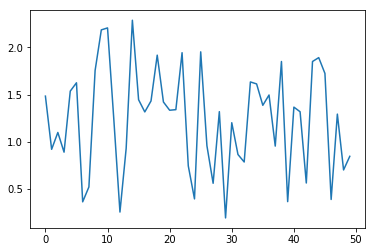

In [25]:
#all_driving = np.around(all_driving * 0.621371, decimals = 3)
all_driving = np.around(all_driving, decimals = 3)
np.set_printoptions(suppress=True)
print (all_driving)
print (np.around (all_driving.mean(), decimals = 3))
print (np.around (np.median(all_driving), decimals = 3))
plt.plot(all_driving)

In [19]:
kmeans_rt = all_driving

In [13]:
wass_rt = all_driving

In [26]:
none_rt = all_driving

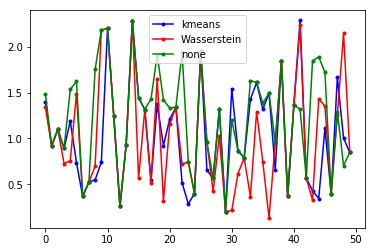

In [27]:
#round_rt = all_driving
plt.plot(kmeans_rt, 'b.-', label = 'kmeans')
plt.plot(wass_rt, 'r.-', label = 'Wasserstein')
plt.plot(none_rt, 'g.-', label = 'none')
plt.legend()

kmeans:  median:  0.9265000000000001 mean:  1.0258600000000002
wass:  median:  0.884 mean:  0.99068
none:  1.3185 mean:  1.2336400000000003


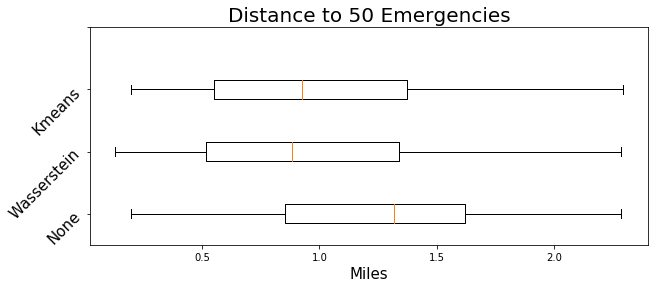

In [28]:
data = [kmeans_rt, wass_rt, none_rt]
print ('kmeans: ', 'median: ', np.median (kmeans_rt), 'mean: ', kmeans_rt.mean())
print ('wass: ', 'median: ', np.median (wass_rt), 'mean: ', wass_rt.mean())
print ('none: ', np.median (none_rt), 'mean: ', none_rt.mean())

labels=['',
        'Kmeans',
        'Wasserstein',
        'None']

x_pos = np.arange(4)

# Multiple box plots on one Axes
fig, ax = plt.subplots(figsize=(10,4))
bp = ax.boxplot(data, notch = 0, sym = '+', vert=0, whis=1.5)
plt.setp(bp['fliers'], color='red', marker='o')
ax.set_xlabel("Miles", fontsize = 15)
ax.set_yticks(x_pos)
ax.set_yticklabels(labels, rotation=45, fontsize = 15)
ax.invert_yaxis()
plt.title("Distance to 50 Emergencies", fontsize = 20)
plt.show()

In [152]:
tosave = ax.get_figure()
tosave.savefig('Miles.png', bbox_inches='tight')

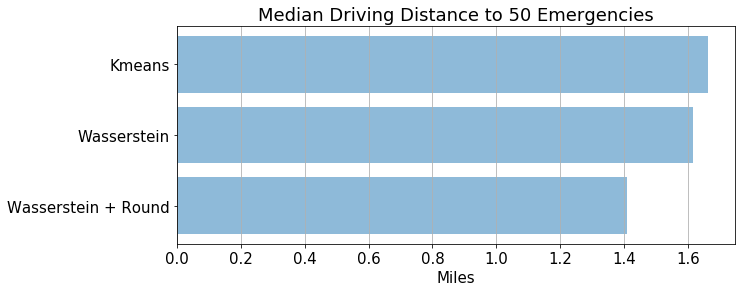

In [65]:
plt.rcParams.update({'font.size': 15, 'text.color' : "black",
                     'axes.labelcolor' : "black"})
labels=['Kmeans',
        'Wasserstein', 
        'Wasserstein + Round']

x_pos = np.arange(len(labels))
CTEs = [1.664,
        1.615, 
        1.408]

fig, ax = plt.subplots(figsize=(10,4))
# color=[11/255,122/255,117/255], 
ax.barh(x_pos, CTEs, alpha=0.5)
ax.set_xlabel("Miles")
ax.set_yticks(x_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
#ax.set_title("Average PAI for 20 predicions over 1, 2, and 4 hours \nfor 50 by 50 grid (cell size of .16 mi^2)")
ax.xaxis.grid(True)
plt.title("Median Driving Distance to 50 Emergencies")
plt.show()